In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm_notebook
from itertools import product

warnings.filterwarnings("ignore")
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [5]:
country = pd.read_csv("D:\Kuliah\BasicStats\EVEN_FinalProj\datasets\GlobalLandTemperaturesByCountry.csv")
country["dt"] = pd.to_datetime(country["dt"])
country.set_index("dt", inplace=True)
country.tail()

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
2013-05-01,19.059,1.022,Zimbabwe
2013-06-01,17.613,0.473,Zimbabwe
2013-07-01,17.000,0.453,Zimbabwe
2013-08-01,19.759,0.717,Zimbabwe
2013-09-01,NaN,NaN,Zimbabwe


,AverageTemperature
dt,
1825-01-01,25.552167
1826-01-01,25.365000
1827-01-01,25.365000
1828-01-01,25.365000
1829-01-01,25.365000
...,...
2009-01-01,26.455000
2010-01-01,26.537000
2011-01-01,26.202250


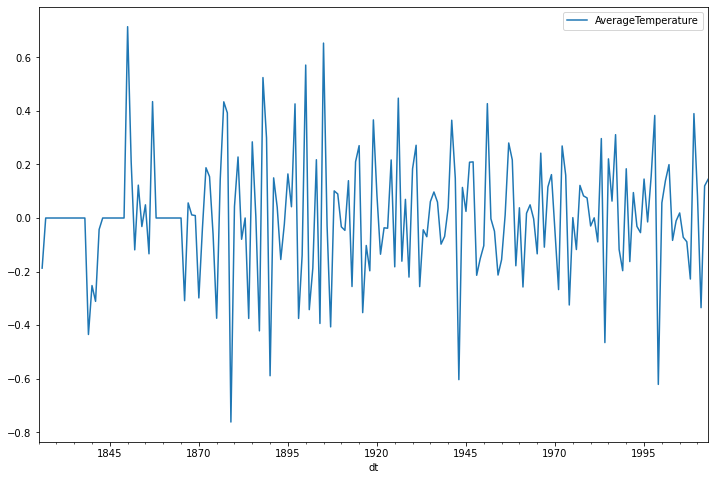

In [3]:
# filtering the dataframe to show only Indonesia
indo = country.copy()
indo = indo.loc[indo["Country"] == "Indonesia"]
indo.fillna(method='bfill', inplace=True)

# resampling the data to show the average temp of each decade
filtered = indo.resample("AS").mean()
filtered.drop("AverageTemperatureUncertainty", axis=1, inplace=True)

# first order of differentials
filtered.diff().plot(figsize=(12,8))
filtered

In [4]:
# checking the stationarity of the time series using Augmented Dicky-Fuller test
# finding the p value to proceed with differencing
# since p-value is larger than chosen threshold (5%), time series is not stationary
result = adfuller(filtered.AverageTemperature)
print("ADF Statistic: %f" %result[0])
print("p-value: %f" %result[1])

ADF Statistic: -1.155791
p-value: 0.692318


In [5]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = ARIMA(exog, order=order).fit(disp=0)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [6]:
# checking the best ARIMA model
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# make a list with all possible combination of p, d, q
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []
for parameter in parameters_list:
    parameter = list(parameter)
    parameter.insert(1, 1)
    parameter = tuple(parameter)
    order_list.append(parameter)

results_df = optimize_ARIMA(order_list, filtered.AverageTemperature)

results_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(7, 1, 6)",-58.124045
1,"(5, 1, 7)",-56.956456
2,"(7, 1, 7)",-56.217097
3,"(4, 1, 6)",-55.973927
4,"(1, 1, 6)",-55.622476
5,"(3, 1, 6)",-55.531364
6,"(2, 1, 6)",-54.354433
7,"(4, 1, 7)",-53.973978
8,"(1, 1, 7)",-53.629365
9,"(6, 1, 4)",-53.287011


In [7]:
# according to the test above, the best model is the 716 model
model = ARIMA(filtered.AverageTemperature, order=(7,1,6))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARIMA Model Results                               
Dep. Variable:     D.AverageTemperature   No. Observations:                  188
Model:                   ARIMA(7, 1, 6)   Log Likelihood                  44.062
Method:                         css-mle   S.D. of innovations              0.188
Date:                  Sun, 02 Jan 2022   AIC                            -58.124
Time:                          23:58:04   BIC                             -9.577
Sample:                      01-01-1826   HQIC                           -38.455
                           - 01-01-2013                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0076      0.001     13.334      0.000       0.006       0.009
ar.L1.D.AverageTemperature     0.1819      0.156      1.165      0.

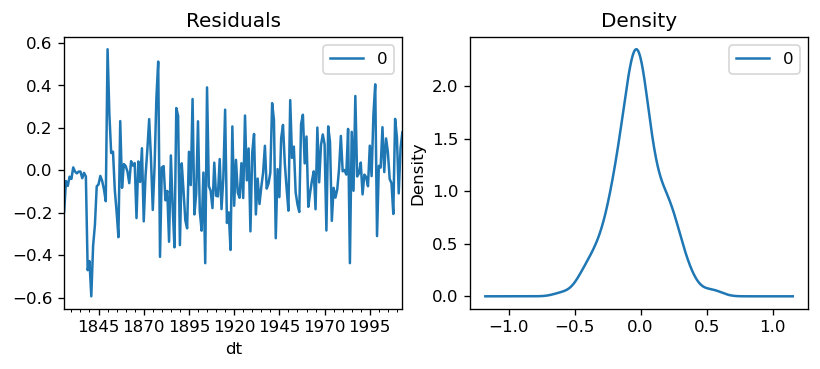

In [8]:
residuals = pd.DataFrame(model_fit.resid)
plt.rcParams.update({"figure.figsize": (8, 3), 'figure.dpi':120})
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title="Density", ax=ax[1])
plt.show()

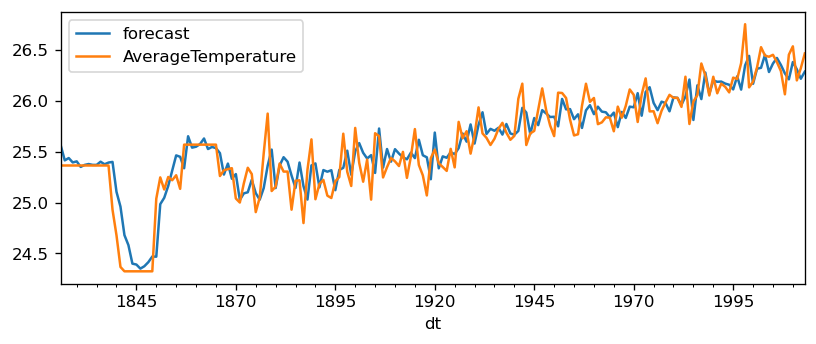

In [9]:
model_fit.plot_predict(dynamic=False)
plt.show()

[26.372830754731552, 26.352653361095555, 26.27327532479262, 26.291502685125785, 26.37102616905984, 26.281786152721452, 26.2795025290255, 26.338090865009615, 26.286781674978116, 26.297260790893, 26.349446917250127, 26.306864408682465, 26.3340599904121, 26.377788777467284, 26.352380192656227, 26.381978152031575, 26.42322134059554, 26.404338851632787, 26.43871181028195, 26.470100050061344, 26.45908893152774, 26.489020466796116, 26.5144244624995, 26.50359146652028, 26.53068235653295, 26.54611835860433, 26.537256804071607, 26.557313413717054, 26.56694641032159, 26.556854538489542]


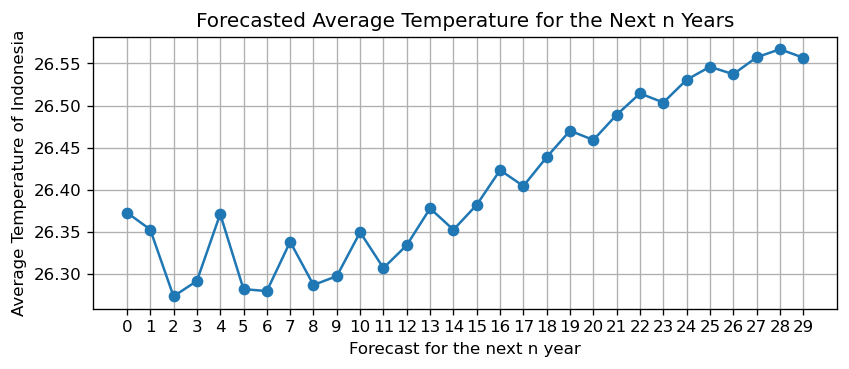

In [12]:
forecast = model_fit.forecast(steps=30)[0]
forecast_values = []
for value in forecast:
    forecast_values.append(value)

plt.plot(range(0, len(forecast_values)), forecast_values, marker="o")
plt.xticks(range(0, len(forecast_values)))
plt.xlabel("Forecast for the next n year")
plt.ylabel("Average Temperature of Indonesia")
plt.title("Forecasted Average Temperature for the Next n Years")
plt.grid()
print(forecast_values)